In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


### Data Processing

In [27]:
df= pd.read_csv('data.csv')
df.head()

,url,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,https://www.netflix.com/title/60000724,Forrest Gump,Movie,"Drama, Romance",1994.0,tt0109830,8.8,2311997.0,"AD, AE, AG, AL, AO, AR, AT, AU, BA, BB, BE, BG..."
1,https://www.netflix.com/title/1154386,The Fifth Element,Movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,516291.0,"AT, CH, DE"
2,https://www.netflix.com/title/60031236,Kill Bill: Vol. 1,Movie,"Action, Crime, Thriller",2003.0,tt0266697,8.2,1219973.0,"AE, AL, AO, AT, AU, AZ, BG, BH, BY, CA, CI, CM..."
3,https://www.netflix.com/title/70021659,Jarhead,Movie,"Biography, Drama, War",2005.0,tt0418763,7.0,211218.0,"AD, AE, AG, AL, AO, AR, AT, AZ, BA, BB, BE, BG..."
4,https://www.netflix.com/title/1080395,Unforgiven,Movie,"Drama, Western",1992.0,tt0105695,8.2,443163.0,"AU, BA, BE, BG, CZ, HR, HU, MD, ME, MK, NZ, PL..."


In [28]:
df.isnull().sum()

url                   12465
title                   503
type                      0
genres                  131
releaseYear              12
imdbId                  604
imdbAverageRating       636
imdbNumVotes            636
availableCountries        0
dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14284 entries, 0 to 14283
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url                 1819 non-null   object 
 1   title               13781 non-null  object 
 2   type                14284 non-null  object 
 3   genres              14153 non-null  object 
 4   releaseYear         14272 non-null  float64
 5   imdbId              13680 non-null  object 
 6   imdbAverageRating   13648 non-null  float64
 7   imdbNumVotes        13648 non-null  float64
 8   availableCountries  14284 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1004.5+ KB


In [30]:
df.describe()

,releaseYear,imdbAverageRating,imdbNumVotes
count,14272.000000,13648.000000,1.364800e+04
mean,2009.754204,6.529089,4.167379e+04
std,15.783869,1.053577,1.398605e+05
min,1913.000000,1.200000,5.000000e+00
25%,2007.000000,5.900000,4.550000e+02
50%,2015.000000,6.600000,2.237500e+03
75%,2019.000000,7.300000,1.684750e+04
max,2024.000000,9.500000,2.954554e+06


In [31]:
df = df.dropna(subset=['releaseYear'])
df = df[df['releaseYear'] != float('inf')]
df['releaseYear'] = df['releaseYear'].astype(int)

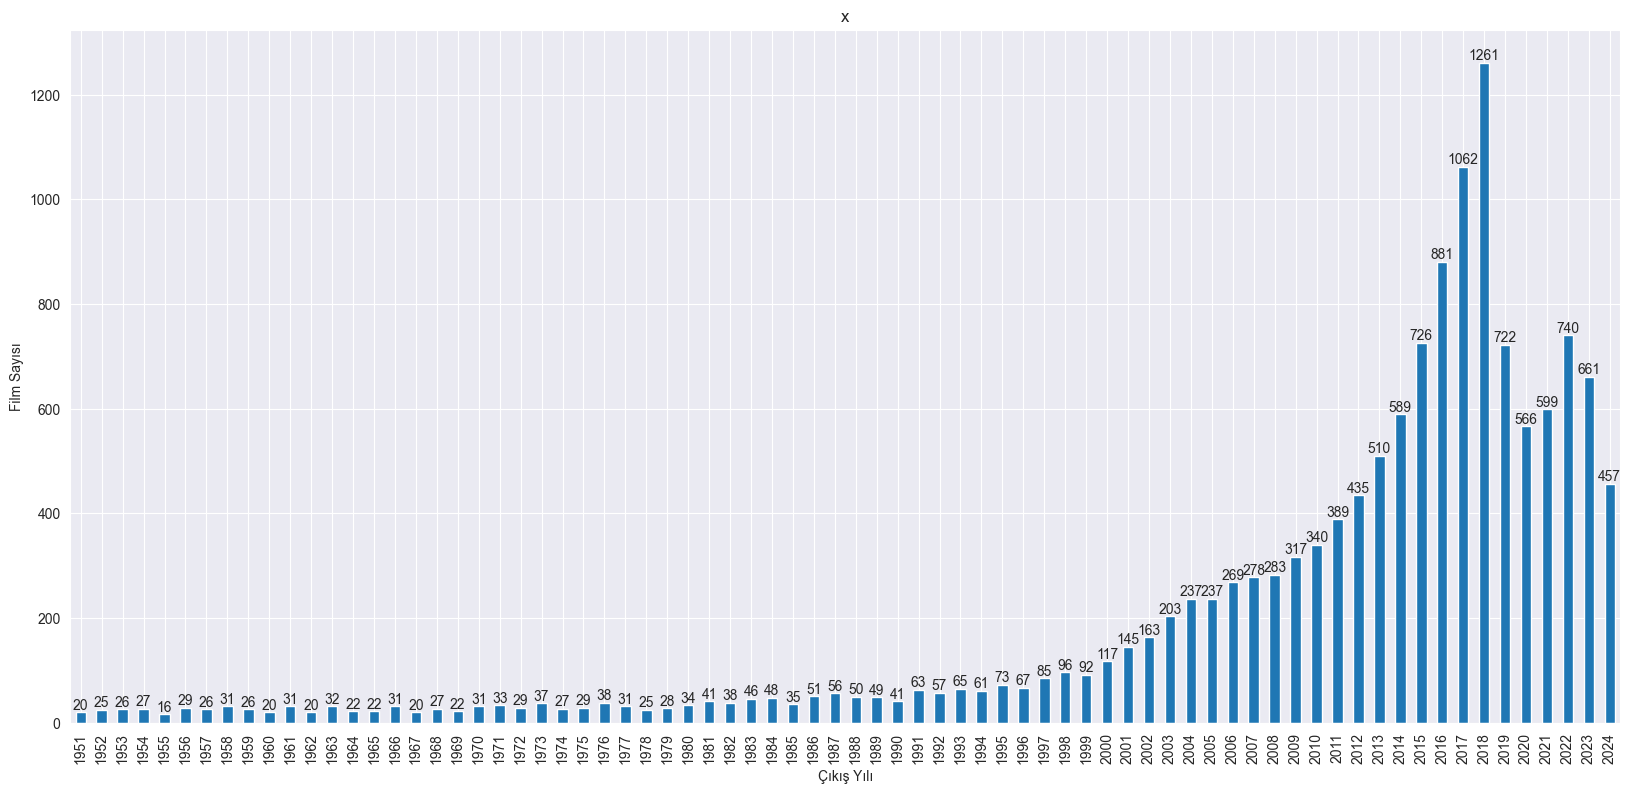

In [32]:
filtered_df = df[df['releaseYear'] > 1950]
ax = filtered_df['releaseYear'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(20, 9))
plt.title('x')
plt.xlabel('Çıkış Yılı')
plt.ylabel('Film Sayısı')

for p in ax.containers:
    ax.bar_label(p, label_type='edge')

plt.show()

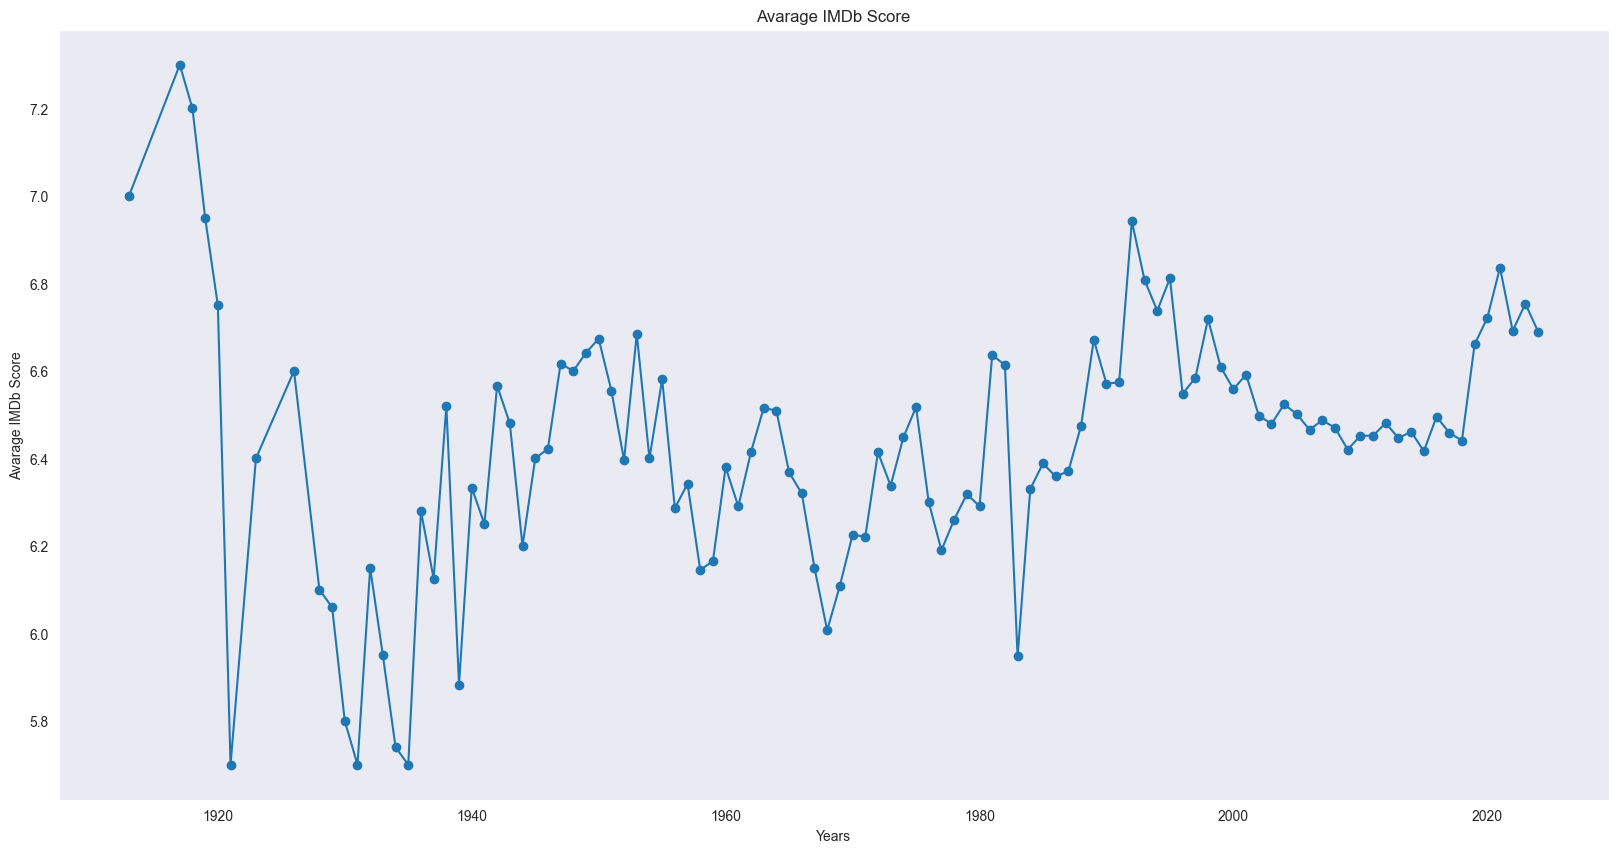

In [33]:
avg_rating_by_year = df.groupby('releaseYear')['imdbAverageRating'].mean()

plt.figure(figsize=(20, 10))
avg_rating_by_year.plot(kind='line', marker='o')
plt.title('Avarage IMDb Score')
plt.xlabel('Years')
plt.ylabel('Avarage IMDb Score')
plt.grid()
plt.show()

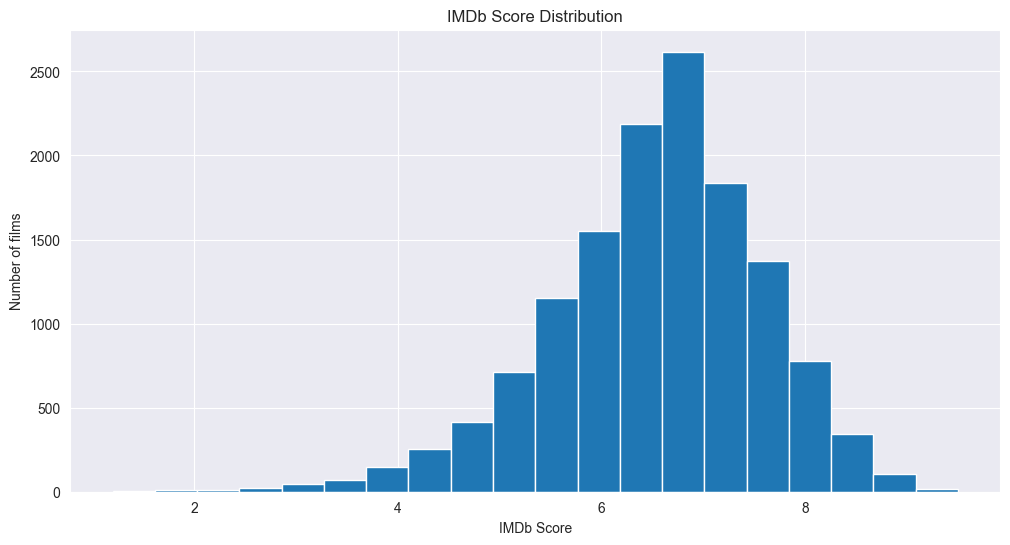

In [34]:
plt.figure(figsize=(12, 6))
plt.hist(df['imdbAverageRating'].dropna(), bins=20)
plt.title('IMDb Score Distribution')
plt.xlabel('IMDb Score')
plt.ylabel('Number of films')
plt.show()


<Axes: xlabel='type'>

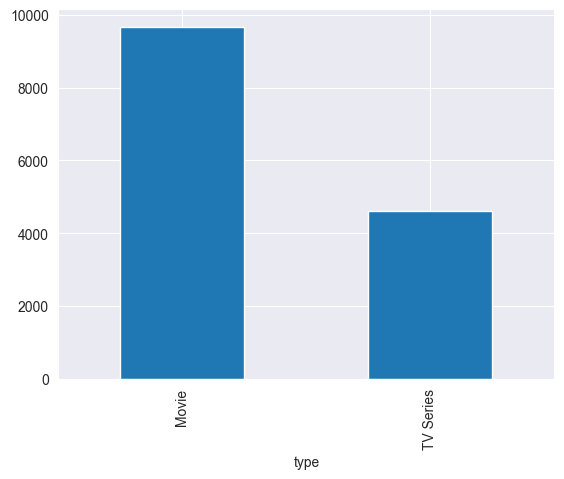

In [35]:
df['type'].value_counts().plot(kind = 'bar')

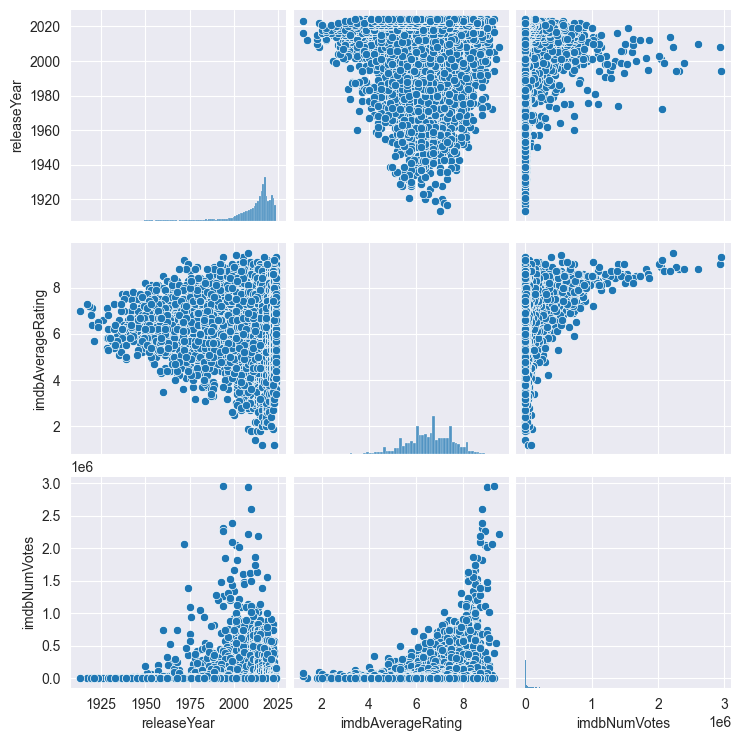

In [36]:
sns.pairplot(df)

In [37]:
# Missing data cleaning
df = df.dropna(subset=['imdbAverageRating'])
# Selection of Feature and Target Variables
X = df[['releaseYear', 'genres', 'availableCountries']]
y = df['imdbAverageRating']
# Filling Missing Values
X['releaseYear'].fillna(X['releaseYear'].median(), inplace=True)
X['genres'].fillna('Unknown', inplace=True)
X['availableCountries'].fillna('Unknown', inplace=True)


/var/folders/d0/zdy0l5wj1md07992x9j7fdtm0000gn/T/ipykernel_2315/1199284838.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['releaseYear'].fillna(X['releaseYear'].median(), inplace=True)
/var/folders/d0/zdy0l5wj1md07992x9j7fdtm0000gn/T/ipykernel_2315/1199284838.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['releaseYear'].fillna(X[

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('genres', OneHotEncoder(handle_unknown='ignore'), ['genres']),
        ('countries', OneHotEncoder(handle_unknown='ignore'), ['availableCountries'])
    ],
)

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred) 

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Erorr: {mae}")
print(f"Predicts: {y_pred}")

Mean Squared Error: 1.0015035414697795
R^2 Score: 0.1385757470861586
Mean Absolute Erorr: 0.7661077096331047
Predicts: [6.62883541 5.9760631  5.26296829 ... 5.26296829 6.19018591 5.76482759]


In [49]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', DecisionTreeRegressor())])
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred) 

print(f"Mean Squared Error (Decision Tree): {mse}")
print(f"R^2 Score (Decision Tree): {r2}")
print(f"Mean Absolute Erorr: {mae}")
print(f"Tahminler (Decision Tree): {y_pred}")

Mean Squared Error (Decision Tree): 1.1175978230734134
R^2 Score (Decision Tree): 0.03871945536380217
Mean Absolute Erorr: 0.8138168403635878
Tahminler (Decision Tree): [6.875      5.94166667 6.3        ... 6.3        6.95       6.5       ]


In [50]:

model_pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', RandomForestRegressor(n_estimators=100))])

model_pipeline_rf.fit(X_train, y_train)

y_pred_rf = model_pipeline_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred) 

print(f"Mean Squared Error (Random Forest): {mse_rf}")
print(f"R^2 Score (Random Forest): {r2_rf}")
print(f"Mean Absolute Erorr: {mae}")
print(f"Tahminler (Random Forest): {y_pred_rf}")

Mean Squared Error (Random Forest): 0.9792881652646263
R^2 Score (Random Forest): 0.1576838810650354
Mean Absolute Erorr: 0.8138168403635878
Tahminler (Random Forest): [6.70048564 5.90774553 5.933      ... 5.933      6.39588333 6.299     ]


In [51]:
from sklearn.svm import SVR
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='linear')) 
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)  

print(f"Mean Squared Error (SVM): {mse}")
print(f"R^2 Score (SVM): {r2}")
print(f"Mean Absolute Erorr: {mae}")
print(f"Predictions: {y_pred}")

Mean Squared Error (SVM): 0.9598077509927322
R^2 Score (SVM): 0.1744395894732066
Mean Absolute Erorr: 0.7527264851585037
Tahminler: [6.37692593 5.91313423 5.71824433 ... 5.71824433 6.22899845 5.96230526]
